In [1]:
import pyannote.core
from pydub import AudioSegment
import os
import json
from pyannote.core import Timeline, Segment

In [90]:
file = {'uri':'1043_meal', 'audio':'/Users/andrei-macpro/Documents/Data/Audio/sad_demonstration/speech2.wav'}

In [91]:
file_pydub = AudioSegment.from_wav("/Users/andrei-macpro/Documents/Data/Audio/sad_demonstration/speech2.wav")

In [4]:
import torch
# overlapped speech detection trained on ami training set
model = torch.hub.load('pyannote/pyannote-audio', 'ovl_dihard')

Using cache found in /Users/andrei-macpro/.cache/torch/hub/pyannote_pyannote-audio_master


In [92]:
osd = model({'audio':'/Users/andrei-macpro/Documents/Data/Audio/sad_demonstration/speech2.wav'})

In [93]:
from pyannote.audio.utils.signal import Binarize
binarize = Binarize(offset=0.55, onset=0.55, log_scale=True, 
                    min_duration_off=0.1, min_duration_on=0.1)

# overlapped speech regions (as `pyannote.core.Timeline` instance)
overlap = binarize.apply(osd, dimension=1)

In [94]:
beginning = Segment(start =0 , end=overlap[0].start)
end = Segment(start = overlap[len(overlap)-1].end  , end = file_pydub.duration_seconds )

In [52]:
beginning, end

(<Segment(0, 23.701)>, <Segment(625.511, 653.752)>)

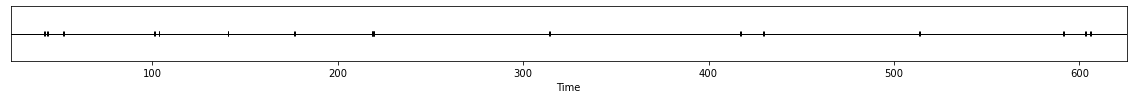

In [95]:
# we're now making a complete file timeline in order to then extract the segments with overlapping speech
no_os=Timeline()
                    
for segment in overlap.gaps():
    no_os.add(segment)
no_os.add(beginning)
no_os.add(end)

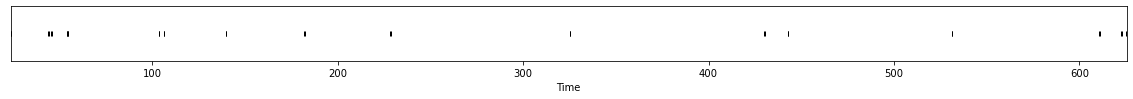

In [71]:
overlap

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from pyannote.core import Segment, notebook

In [44]:
notebook.crop = None
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)


(-0.1, 1.1)

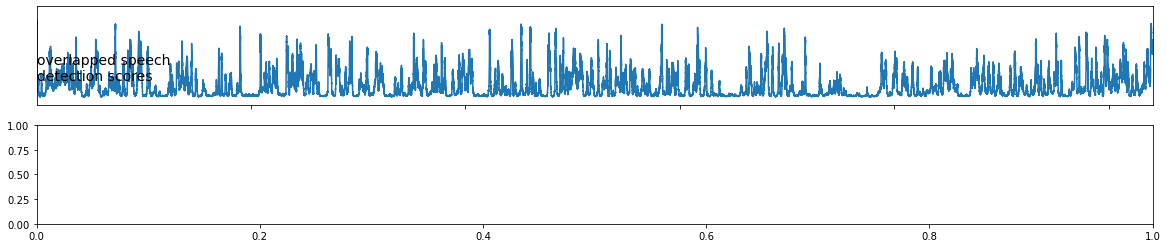

In [47]:
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)

notebook.plot_feature(plot_ready(ovd), ax=ax[0], time=False)
ax[0].text(notebook.crop.start + 0.5, 0.2, 'overlapped speech\ndetection scores', fontsize=14)
ax[0].set_ylim(-0.1, 1.1)

In [96]:
timestamps_ovd=dict(overlap)
timestamps_no_ovd = dict(no_os)

In [97]:
start_times_os=[x*1000 for x in list(timestamps_ovd.keys())]
end_times_os=[x*1000 for x in list(timestamps_ovd.values())]

In [98]:
start_times_no_os=[x*1000 for x in list(timestamps_no_ovd.keys())]
end_times_no_os=[x*1000 for x in list(timestamps_no_ovd.values())]

In [99]:
speech_segments=[file_pydub[start_time:end_time] for start_time,end_time in zip(start_times_os, end_times_os)]

In [100]:
no_overlap = [file_pydub[start_time:end_time] for start_time,end_time in zip(start_times_no_os, end_times_no_os)]

In [101]:
sum(speech_segments).export('/Users/andrei-macpro/Documents/Data/Audio/os2.0_1043.wav', format="wav")


<_io.BufferedRandom name='/Users/andrei-macpro/Documents/Data/Audio/os2.0_1043.wav'>

In [102]:
sum(no_overlap).export('/Users/andrei-macpro/Documents/Data/Audio/no_os2.0_1043.wav', format="wav")


<_io.BufferedRandom name='/Users/andrei-macpro/Documents/Data/Audio/no_os2.0_1043.wav'>

In [103]:
# ok so it makes no difference if the input to OSD is the voiced parts or the voiced(voiced parts)